In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [4]:
df = pd.read_csv('bitcoin_history1_clean.csv')
df = df.set_index('block_time')


# List of fee rate columns that need to be converted from BTC/vB to sat/vB
fee_rate_columns = ['max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_median_fee_rate']


for col in fee_rate_columns:
    df[col] = df[col] * 10**8


print(df[fee_rate_columns].head())

                     max_fee_rate  avg_fee_rate  median_fee_rate  \
block_time                                                         
2023-08-15 13:04:26         200.0      2.546653          2.31746   
2023-08-15 13:07:55         200.0      2.547332          2.31746   
2023-08-15 13:08:04         200.0      2.547714          2.31746   
2023-08-15 13:16:21         200.0      2.548790          2.31746   
2023-08-15 13:26:12         200.0      2.550336          2.31746   

                     fee_rate_10th  fee_rate_90th  fee_rate_std  \
block_time                                                        
2023-08-15 13:04:26       2.206349       2.492063      2.449531   
2023-08-15 13:07:55       2.206349       2.492754      2.449685   
2023-08-15 13:08:04       2.206349       2.500000      2.449535   
2023-08-15 13:16:21       2.206349       2.500000      2.451369   
2023-08-15 13:26:12       2.206349       2.500000      2.456636   

                     block_median_fee_rate  
block_ti

In [5]:
# Define features (X) and target (y)
X = df.drop(columns=['block_median_fee_rate'])
y = df['block_median_fee_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
target_variable = 'block_median_fee_rate'

Variance Inflation Factors:
              feature          VIF
0        block_height    30.806222
1            tx_count   285.928524
2     mempool_size_mb  2471.713739
3        max_fee_rate     7.634929
4        avg_fee_rate    36.660868
5     median_fee_rate     5.843744
6       fee_rate_10th     9.258396
7       fee_rate_90th     3.262774
8        fee_rate_std    15.380481
9          difficulty    29.974701
10          hash_rate     4.202918
11          total_fee   360.038206
12      mempool_usage  2959.568056
13  transaction_count     1.184473
14       block_weight     1.002625
15      block_version     1.003254
16     block_interval     1.002535
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=255578.869, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=249423.095, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC

/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


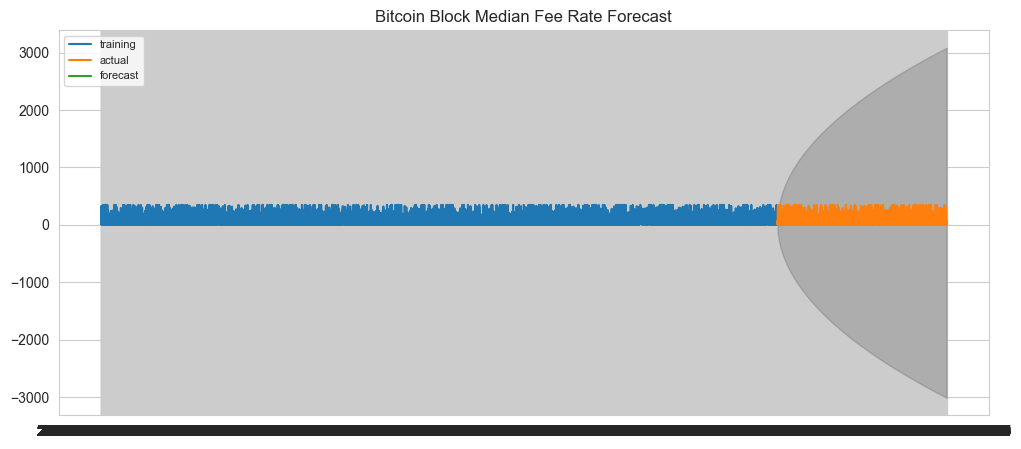

Mean Squared Error: 4779.450294564634
Mean Absolute Error: 40.089969410144086
Root Mean Squared Error: 69.13356850738022
R-squared Score: -0.09338031368976063


In [8]:
# Separate target variable from exogenous variables
exog_variables = [col for col in X_train.columns if col != target_variable]

# Scale the exogenous variables
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[exog_variables]), 
                                 columns=exog_variables, index=X_train.index)
exog_test_scaled = pd.DataFrame(scaler.transform(X_test[exog_variables]), 
                                columns=exog_variables, index=X_test.index)

# Check for multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_results = calculate_vif(exog_train_scaled)
print("Variance Inflation Factors:")
print(vif_results)

# Fit auto ARIMA
model = auto_arima(y_train, exogenous=exog_train_scaled, start_p=1, start_q=1, max_p=5, max_q=5, m=1,
                   start_P=0, seasonal=False, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)


print(model.summary())

# Forecast
n_periods = len(y_test)
fc, confint = model.predict(n_periods=n_periods, exogenous=exog_test_scaled, return_conf_int=True)

# Create a DataFrame with the forecasts
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(confint[:, 0], index=y_test.index)
upper_series = pd.Series(confint[:, 1], index=y_test.index)

# Plot the forecasts
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title(f'Bitcoin {target_variable.replace("_", " ").title()} Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mse = mean_squared_error(y_test, fc)
mae = mean_absolute_error(y_test, fc)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, fc)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared Score: {r2}')



The negative R-squared score suggests that the model's performance is poor - it's performing worse than a horizontal line (mean of the data). This could be due to several reasons:

The relationship between the features and the target might be non-linear.
There might be high volatility in the data that the ARIMA model can't capture well.
The chosen features might not be predictive of the target variable.
The ARIMA model might not be the best choice for this particular dataset.

# Hybrid model

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import time
import random
import ast


def set_seed(seed=42):
    # Python's random
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    
def preprocess_list_columns(df):
    """Convert string representations of lists to actual numerical features"""
    list_columns = []
    
    # Identify columns containing lists
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                if isinstance(ast.literal_eval(df[col].iloc[0]), list):
                    list_columns.append(col)
            except (ValueError, SyntaxError):
                continue
    
    # Process list columns
    for col in list_columns:
        # Convert string representations to actual lists
        lists = df[col].apply(ast.literal_eval)
        
        # Create new features from lists
        df[f'{col}_mean'] = lists.apply(lambda x: np.mean(x))
        df[f'{col}_std'] = lists.apply(lambda x: np.std(x))
        df[f'{col}_max'] = lists.apply(lambda x: max(x))
        df[f'{col}_min'] = lists.apply(lambda x: min(x))
        df[f'{col}_range'] = lists.apply(lambda x: max(x) - min(x))
        df[f'{col}_sum'] = lists.apply(lambda x: sum(x))
        
        # Drop the original list column
        df = df.drop(columns=[col])
    
    return df

def create_advanced_features(df):
    # First preprocess any list columns
    df = preprocess_list_columns(df)
    
    # Time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Get numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Rolling statistics for numerical columns
    windows = [6, 12, 24]  # 1h, 2h, 4h in 10-minute blocks
    for col in numeric_cols:
        if col != 'block_median_fee_rate':  # Skip target variable
            for window in windows:
                df[f'{col}_mean_{window}'] = df[col].rolling(window=window).mean()
                df[f'{col}_std_{window}'] = df[col].rolling(window=window).std()
    
    # Basic feature interactions
    if 'mempool_size_mb' in df.columns and 'transaction_count' in df.columns:
        df['mempool_pressure'] = df['mempool_size_mb'] * df['transaction_count']
    
    if 'bitcoin_price_usd' in df.columns:
        df['price_volatility'] = df['bitcoin_price_usd'].pct_change().rolling(12).std()
    
    # Fill NaN values with appropriate methods
    for col in df.columns:
        if col.endswith(('_mean', '_std', '_volatility')):
            df[col] = df[col].fillna(method='bfill')
        else:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

def forecast_exog_advanced(X, steps):
    forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), 
                                              periods=steps, freq='10T'))
    
    for col in X.columns:
        if col.startswith(('hour_', 'day_')):
            if 'hour_' in col:
                hour = forecast.index.hour
                forecast[col] = np.sin(2 * np.pi * hour / 24) if 'sin' in col else np.cos(2 * np.pi * hour / 24)
            else:
                day = forecast.index.dayofweek
                forecast[col] = np.sin(2 * np.pi * day / 7) if 'sin' in col else np.cos(2 * np.pi * day / 7)
        else:
            # Use exponential smoothing for numerical features
            alpha = 0.7
            last_values = X[col].iloc[-10:]
            smoothed_value = last_values.ewm(alpha=alpha).mean().iloc[-1]
            forecast[col] = smoothed_value
    
    return forecast

class HybridModel:
    def __init__(self, sarimax_order=(1,1,1)):
        self.sarimax_order = sarimax_order
        self.sarimax_model = None
        self.gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.8,
            random_state=42
        )
        
    def fit(self, y, exog):
        # Fit SARIMAX
        self.sarimax_model = SARIMAX(y, exog=exog, order=self.sarimax_order)
        self.sarimax_results = self.sarimax_model.fit()
        
        # Get SARIMAX residuals
        sarimax_pred = self.sarimax_results.get_prediction(start=0, exog=exog)
        residuals = y - sarimax_pred.predicted_mean
        
        # Fit GradientBoosting on residuals
        self.gb_model.fit(exog, residuals)
        
    def predict(self, exog):
        sarimax_pred = self.sarimax_results.get_prediction(
            start=len(self.sarimax_results.fittedvalues), 
            end=len(self.sarimax_results.fittedvalues) + len(exog) - 1,
            exog=exog
        )
        gb_pred = self.gb_model.predict(exog)
        return sarimax_pred.predicted_mean + gb_pred
    
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator


def plot_fold_results(y_true, y_pred, fold_idx):
    """Plot results for a single fold"""
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true) + 1), y_true, label='Actual')
    plt.plot(range(1, len(y_pred) + 1), y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1} - 144 Blocks)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_all_folds(all_y_true, all_y_pred):
    """Plot results for all folds combined"""
    plt.figure(figsize=(15, 8))
    plt.plot(range(1, len(all_y_true) + 1), all_y_true, label='Actual')
    plt.plot(range(1, len(all_y_pred) + 1), all_y_pred, label='Predicted')
    plt.title('Actual vs Predicted Bitcoin Fee Rates (All Folds Combined)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def run_improved_model(df, test_size=144, n_splits=5):
    # Prepare data with advanced feature engineering
    df = create_advanced_features(df)
    
    # Select features (excluding target)
    features = [col for col in df.columns if col != 'block_median_fee_rate']
    target = 'block_median_fee_rate'
    
    X = df[features]
    y = df[target]
    
    # Scale features
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Initialize metrics storage
    metrics = {metric: [] for metric in ['mae', 'rmse', 'r2', 'mape', 'da', 'theil_u']}
    all_y_true = []
    all_y_pred = []
    
    # Cross-validation
    n_total = len(X_scaled)
    for fold_idx in range(n_splits):
        print(f"\nTraining fold {fold_idx+1}/{n_splits}")
        
        train_end = n_total - (n_splits - fold_idx) * test_size
        test_start = train_end
        test_end = test_start + test_size
        
        # Split data
        train_X = X_scaled.iloc[:train_end]
        train_y = y.iloc[:train_end]
        test_y = y.iloc[test_start:test_end]
        
        # Fit model
        model = HybridModel()
        model.fit(train_y, train_X)
        
        # Generate forecasts
        future_exog = forecast_exog_advanced(train_X, test_size)
        predictions = model.predict(future_exog)
        
        # Store results
        y_true = test_y.values[:test_size]
        y_pred = predictions[:test_size]
        
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        
        # Plot results for current fold
        plot_fold_results(y_true, y_pred, fold_idx)
        
        # Calculate metrics
        metrics['mae'].append(mean_absolute_error(y_true, y_pred))
        metrics['rmse'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        metrics['r2'].append(r2_score(y_true, y_pred))
        metrics['mape'].append(mean_absolute_percentage_error(y_true, y_pred))
        metrics['da'].append(directional_accuracy(y_true, y_pred))
        metrics['theil_u'].append(theil_u(y_true, y_pred))
        
        # Print metrics for current fold
        print(f"\nFold {fold_idx + 1} Metrics:")
        print(f"MAE: {metrics['mae'][-1]:.4f}")
        print(f"RMSE: {metrics['rmse'][-1]:.4f}")
        print(f"R²: {metrics['r2'][-1]:.4f}")
        print(f"MAPE: {metrics['mape'][-1]:.4f}%")
        print(f"Directional Accuracy: {metrics['da'][-1]:.4f}%")
        print(f"Theil's U: {metrics['theil_u'][-1]:.4f}")
    
    # Plot all folds combined
    plot_all_folds(all_y_true, all_y_pred)
    
    # Create DataFrame with metrics for each fold
    metrics_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'MAE': metrics['mae'],
        'RMSE': metrics['rmse'],
        'R2': metrics['r2'],
        'MAPE': metrics['mape'],
        'DirectionalAccuracy': metrics['da'],
        'TheilsU': metrics['theil_u']
    })
    
    print("\nDetailed metrics for each fold:")
    print(metrics_df)
    
    # Print cross-validation results
    print("\nCross-Validation Performance:")
    for metric, values in metrics.items():
        print(f"{metric.upper()}: {np.mean(values):.4f} (±{np.std(values):.4f})")
    
    return metrics, all_y_true, all_y_pred, metrics_df

# Usage example:
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('real_time_cleaned.csv')
    df['block_time'] = pd.to_datetime(df['block_time'])
    df = df.sort_values('block_time').set_index('block_time')

    # Set random seed and start timer
    set_seed(42)
    start = time.time()

    # Run the improved model
    metrics, all_y_true, all_y_pred, metrics_df = run_improved_model(df)

    # Print execution time
    end = time.time()
    print(f"\nTraining and Prediction time: {end-start:.2f}s")